<a href="https://colab.research.google.com/github/hn11-44/AMD/blob/main/AMD_LinkedIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of the Project

**Goal** : Finding frequent skills sets using a [LinkedIn Job & Skill](https://https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
) dataset.


**Algorithm**:  Apriori Algorithm

# Install Required Libraries

The first important task would be to install any packages that will be required for this specific project.

1) pyspark

2) ipython-autotime

In [2]:
! pip install pyspark py4j ipython-autotime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00


# Import Libraries

In [4]:
# Import all necessary libraries
from google.colab import userdata
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import re
import pyarrow
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml.feature import StopWordsRemover
from itertools import combinations
%load_ext autotime

time: 511 µs (started: 2024-12-08 21:52:32 +00:00)


For this project we will be using [LinkedIn Job & Skill](https://https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
) data set , which can be accessed from Kaggle.

Descroption of the data set is as follows:

"LinkedIn is a widely used professional networking platform that hosts millions of job postings. This dataset contains 1.3 million job listings scraped from LinkedIn in the year 2024.

This dataset can be used for various research tasks such as job market analysis, skills mapping, job recommendation systems, and more."

In [7]:
# Setup the environment and the key from Kaggle API stored
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

time: 5.7 s (started: 2024-12-08 21:59:22 +00:00)


In [12]:
!kaggle datasets download -d "asaniczka/1-3m-linkedin-jobs-and-skills-2024"
!unzip "1-3m-linkedin-jobs-and-skills-2024"

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
1-3m-linkedin-jobs-and-skills-2024.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
replace job_skills.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: job_skills.csv          
  inflating: job_summary.csv         
  inflating: linkedin_job_postings.csv  
time: 1min 49s (started: 2024-12-08 22:01:10 +00:00)


# Create SparkSession and Load the Data

In [24]:
def create_spark_session():
  return(
      SparkSession
      .builder
      .appName("LinkedIn Skill Apriori")
      .config("spark.ui.port", "4042")
      .config("spark.dynamicAllocation.enabled", "true")
      .config("spark.memory.offHeap.enabled", "false")
      .config("spark.executor.memory", "8g")
      .config("spark.driver.memory", "8g")
      .enableHiveSupport()
      .getOrCreate()
      )

time: 823 µs (started: 2024-12-08 22:04:45 +00:00)


In [25]:
# Create the spark session by calling the function above
spark = create_spark_session()

time: 8.65 s (started: 2024-12-08 22:04:45 +00:00)


In [27]:
spark

time: 1.98 s (started: 2024-12-08 22:06:11 +00:00)


In [28]:
#Load the data using the spark session we have just created
skills = spark.read.csv("/content/job_skills.csv", header = True, inferSchema = True)

time: 38.3 s (started: 2024-12-08 22:06:16 +00:00)


In [29]:
#Save the file in parquet mode because of its efficiency
skills.write.mode('overwrite').parquet('/content/job_skills.parquet')

time: 29.2 s (started: 2024-12-08 22:06:57 +00:00)


In [42]:
# Read in the parquet file we just stored
skills_parquet = spark.read.parquet("/content/job_skills.parquet")

time: 341 ms (started: 2024-12-08 22:29:59 +00:00)


By using parquet we have more efficiency in even just reading the file. It will be beneficial for getting a quick inspection of the data because of its quick load time.

# Inspecting 'job_skills'

In [31]:
#Let us see what we have in the Schema
skills_parquet.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

time: 5.19 ms (started: 2024-12-08 22:08:54 +00:00)


In [33]:
#Let us get a quick summary of the data
skills_parquet.describe().show()

+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           "* Maintenance, *...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+

time: 36.3 s (started: 2024-12-08 22:09:20 +00:00)


In [34]:
#Inspect the first five rows to the data
skills_parquet.show(5, truncate = False)

+------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                |job_skills                     

By inspecting the structure of the data we can see that we have two features. The first one would contain the link of the job listing and the second is the set of skills that re mentioned for the specific job listing. We are maintly interested in the 'job_skills' column and will thus focus on extracting the values within the column as our object of our analysis. The count of the total amount of listings contained within the data is about 1.3 million.

What is interesting is in the 'job_skills' we can see different types of skills that are required for the specific are comma seperated. This would give us an idea on how to split the different skills when creating our skill set.

Furthrmore, we can also see that different languages are also included in the data as it is extracted from a global professional network. However for this project we will only focusing on the jobs listed that use alphanumeric characters.

# Cleaning & Pre-processing

In order to conduce the Apriori algorithm we will need to clean and pre-process the 'job_skill' column. This is the list of cleaning that will be undertaken for this specific data:

1) Drop NULL values,

2) Drop duplicates,

3) Drop 'job_link' column and replace it with a monotonically increasing id

4) Only keep alphanumeric characters

5) Replace 'and' 'or' and '&' with a comma (,),

6) Remove symbole other than ',.#+/-'

7) Remove '#+' if they are isolated (this would mean retain C+ or C#)

8) Remove all stopwords and 'skill' and 'skills'

9) Kepp all the skills listed uniform by making the lower case.

Cleaning procedure from the third onwards will use a function.

In [43]:
#Drop the Null values that are contained within 'job_skill' and drop duplicates
skills_parquet = (skills_parquet.na.drop(subset = ['job_skills'])
                                .dropDuplicates(['job_link', 'job_skills']))


time: 23 ms (started: 2024-12-08 22:30:02 +00:00)


In [44]:
# Use monotonically increasing id to replace 'job_link' and drop 'job_link '
# Select the order of the 'id' and 'job_skills'
skills_parquet = (skills_parquet.withColumn('id', monotonically_increasing_id())
                                .drop('job_link')
                                .select('id', 'job_skills'))

time: 76.2 ms (started: 2024-12-08 22:30:09 +00:00)


In [45]:
#Create a list with the StopWords frequently used in English
english_stopwords = StopWordsRemover.loadDefaultStopWords("english")
# Extend the list by including 'skill' and 'skills'
english_stopwords.extend(['skill', 'skills'])

time: 61.8 ms (started: 2024-12-08 22:30:12 +00:00)


In [87]:
def clean_skills(skills):

  skills = re.sub(r'[^a-zA-Z0-9\s,\.#\+/.-]','',skills) # Only alphanumerics and some symbols
  skills = re.sub(r'\b(and|or|&)\b',',',skills) # Replacing conjuction words with commas
  skills = re.sub(r'(?<![a-zA-Z0-9])[+#]','',skills) # When (#+) are isolated remove them
  skills = re.sub(r'\b(skill|skills)\b','',skills) #Skill and skill appearing alone are removed
  skills = skills.split()
  # Exvlude all of the StopWords we have also included skill and skills
  skills = ' '.join([skill.lower() for skill in skills if skill.lower() not in set(english_stopwords)])
  skills = skills.split(',')
  skills = [skill.strip() for skill in skills]
  return ', '.join(skills)

time: 1.13 ms (started: 2024-12-08 22:46:17 +00:00)


In [88]:
def clean_listing(listing):
  text = listing['job_skills']
  cleaned_text = clean_skills(text)
  return (listing['id'], cleaned_text)

time: 733 µs (started: 2024-12-08 22:46:22 +00:00)


In [89]:
rdd_skills = skills_parquet.rdd.map(clean_listing)

time: 1.64 ms (started: 2024-12-08 22:46:23 +00:00)


In [90]:
rdd_skills.take(5)

[(0,
  'sales, executive assistant, project management, salesforce, seismic, tableau, microsoft office suite, teams, strong editing, proofreading, proactive, time management, travel management, client management, meeting management, data entry, calendar management, reimbursement, bachelors degree, 8+ years experience, attention detail, professionalism, work ethic, responsibility, integrity, flexibility, client reporting, communication preferences, contact management, organization profiles, call notes, opportunity management, audit reports, client profiles, fund manager profiles, performance management, feedback solicitation, appraisals, administrative support, gift, entertainment compliance, travel approval, expense approval'),
 (1,
  'registered nurse, nursing, bls certification, cpr certification, healthcare, patient care, teamwork, communication, critical thinking, problemsolving, leadership, wisconsin nurse practice act, clinical nurse advancement portfolio cnap, american heart ass

time: 2.37 s (started: 2024-12-08 22:46:23 +00:00)


Just by inspecting some of the listing we can see that the data is clened to a level that would be considered satisfactory. Now we would want to use the following data to create some visualisations and set some working hypothesis before we start running the Apriori algorithm on our data. So in this section we will start by conducting some simple tranformation to get our data ready in DataFrame format.

In [91]:
# Convert preprocessed rdd_skills to DataFrame
skills_df = rdd_skills.toDF(['id', 'job_skills'])

time: 1.04 s (started: 2024-12-08 22:50:55 +00:00)


In [92]:
# Convert the clean_skills into an array by splitting on the commas
skill_listings = (skills_df.withColumn('skill_array', split(col('job_skills'), ",\\s*"))
                           .withColumn('skills_set', array_distinct('skill_array')))

time: 51.2 ms (started: 2024-12-08 22:54:10 +00:00)


In [96]:
skill_listings.printSchema()

root
 |-- id: long (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- skill_array: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- skills_set: array (nullable = true)
 |    |-- element: string (containsNull = false)

time: 2.61 ms (started: 2024-12-08 22:58:46 +00:00)


# Exploratory Data Analaysis

Now that we have prepared our data we can start working with our exploratory analysis. Since our goal is the frequent skill we will be dealing primairly with a visualisation that would enable us to get a glimpse of the most occuring skills through the use of wordcloid. In order to do this we must be able to extract the different skils that are listed in the 'job_skill' column and represent them as as indfividual words and get the frequency for each.

In [102]:
skills_separated = skill_listings.withColumn('skill', explode(col('skills_set')))

time: 65.9 ms (started: 2024-12-08 23:00:27 +00:00)


In [103]:
# Count the different skills within the data for the entire data
skills_count = skills_separated.groupBy('skill').count().orderBy("count", ascending = False)

time: 69.3 ms (started: 2024-12-08 23:00:34 +00:00)


In [104]:
skills_count_pd = skills_count.toPandas()

time: 11min 57s (started: 2024-12-08 23:00:50 +00:00)


In [106]:
# Create a dictionary with the skill and count for the Wordcloud
skills_count_dict = dict(zip(skills_count_pd['skill'], skills_count_pd['count']))

time: 2.44 s (started: 2024-12-08 23:12:50 +00:00)


In [107]:
# Let create the WordcCloud
wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate_from_frequencies(skills_count_dict)

time: 2.44 s (started: 2024-12-08 23:12:54 +00:00)


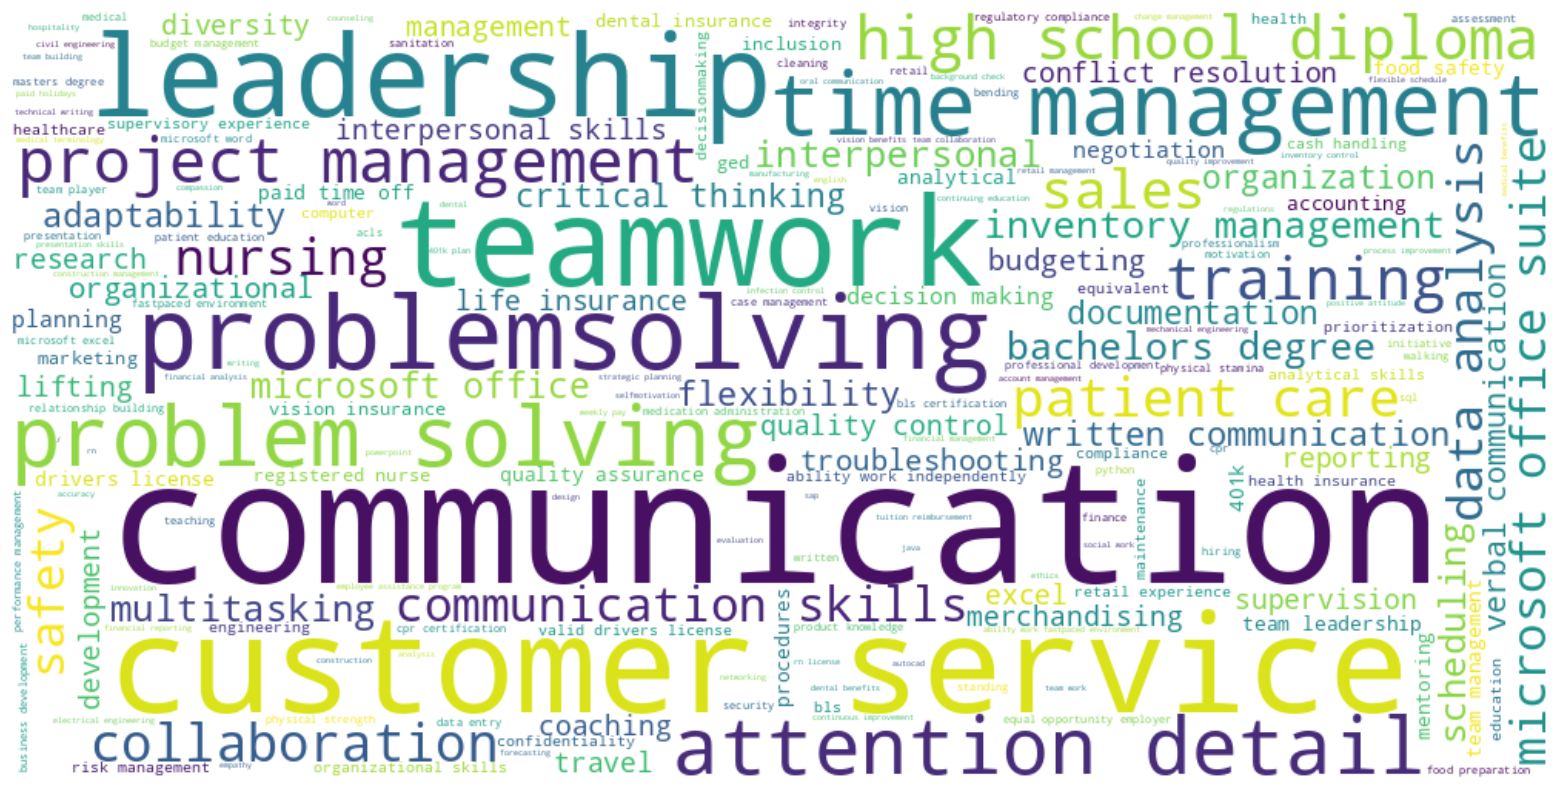

time: 1.32 s (started: 2024-12-08 23:12:58 +00:00)


In [108]:
%matplotlib inline
plt.figure(figsize = (25,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Results from word cloud indicate that skills such as communication, leadership, teamwork, problem solving, customer service and attention to detail are highly promninent in the job listing of our data. But it iw also important to note that other skills such as data analysis, nursing, sales, project management are also present.

We can assume that these are the most frequent skills because they are what are we consider soft skills and they are relevant to most industries, especially profession or white collar jobs. And in the next stage we implement our Apriori Algorithm.

# Algorithm Implemented

For the Apriori algorithm we will be first start by identifying the unique sill sets that are our datat set in order to find the itemsets with meaninglful occurences. To do this we will need to identify the skill set frequencies and combine the skills that appear together with a support above a specified thereshold and filtered out the infrquent skill sets. This process is known as frequent item set mining.

The algorithm combines frequent skill sets further to form larger skill sets. The larger skill sets combination with a lower probability are pruned. This process is repeated until the skill sets meet the defined threshold probability are generated exhaustively. Each iteration generates a complex and comprehensive association in the itemsets.

https://www.ibm.com/topics/apriori-algorithm#:~:text=The%20Apriori%20algorithm%20relies%20on,subsets%20must%20also%20be%20frequent.

Based on the first task that is required is to get the count for the skill set that within our 'skill_set' column. The skill set must conatin $k$ number of unique skills and typically it must contain at least two skills. Now that we have clearly defined what our how our skill set must be represented, our goal would be to get the freqent skill, this is nothing than simply the skill that are listed frequently together.

So just to recap on the algorithm Apriori will be implementing:



1.   Count the frequency of each skill so in this case we will generate a (skill, count) pair for each item
2.   Then we will be filterining out the pairs that are less than the minimal support which will leave us with the frequent items
3. Then we will collect the results to generate candidates and we will repeat the process is repeated for two and three pair of skills.


In the book of Mining of Massive Dataset by JK it is suggested that $k$ never grows beyond 2 or 3.



# Apriori

In the next stage we will be using a modular approach to define the Apriori Algorithms in different function. We will be using a function




1.   Calculate the treshold by multiplying the percentage with the number of total listings from our sample
2.   A function that will determine the frequent singletons from our sample where we will count the frequency of each skills and then prune the unfrequent skills
3. Then we will create candidates by using a nested loop from our singletons frequent then this will also be used when create candidates from our doubleton (k=2)
4. The we prune out the frequent skills generated from the candidates.
5. We put it all togther in a function called apriori where we do the first
pass for the singletons then prun then generate the candidates and keep pruning until we get the maximum candidate we have selected.



In [145]:
def get_threshold(skill_rdd, s):

  return int(skill_rdd.count() * s)
  """
      Value generated from the function get_threshold
        will be used to prune out
      infreqent skill sets from the job listing.

      For example:
      skill_rdd.count() = 100,000
      s = 0.1
      return value will be 10,000
  """

time: 673 µs (started: 2024-12-09 00:25:41 +00:00)


In [154]:
def frequent_singletons(skill_rdd, s_threshold):

  return(
      skill_rdd.flatMap(lambda listing: [(skill, 1) for skill in listing])
               .reduceByKey(lambda value_1, value_2 : value_1 + value_2)
               .filter(lambda skill : skill[1] >= s_threshold)
               .map(lambda skill: (frozenset([skill[0]]), skill[1])))

  """
    We take our listing apply the flatMap transformation to create
    a key-value pari for each skill.
    [("commmunication, 1), ("teamwork", 1), ("leadership", 1)]
    Then we use a second tranformation which will reducebyKey
    to get the sum of the values of the skills.
    We prune by using the filter tranformation any count that is
    below the support_threshold.
    Then we will use the map tranformation to include key-value pairs in the frozenset.

  """


time: 1.4 ms (started: 2024-12-09 00:39:30 +00:00)


In [168]:
def get_candidates(frequent_skills, size):
  frequent_skills = frequent_skills.map(lambda x: x[0]).collect()
  candidates = []
  # Nested loop to generate the candiates from the frequent_skills
  for i in range(len(frequent_skills)):
    for j in range(i+1, len(frequent_skills)):
      candidate = frequent_skills[i].union(frequent_skills[j])
      if len(candidate) == size:
        candidates.append(candidate)

  return spark.sparkContext.parallelize([frozenset(candidate) for candidate in candidates]).distinct()
  """"
    Input:
    frequent_skills =
    [frozenset{'communication'}, 2),
    (frozenset{'teamwork'}, 3),
    (frozenset{'leadership'}, 2)]
    Output:
    candidates =
    [(frozenset{'communication, teamwork"}),
      (frozenset{'communication', leadership}),
      (frozenset{'teamwork', 'communication'})]
    """


time: 1.09 ms (started: 2024-12-09 00:56:54 +00:00)


In [174]:
def find_frequent_skills(skill_rdd, candidates, s_threshold):
  candidate_broadcast = skill_rdd.context.broadcast(candidates.collect())
  return(
          skill_rdd.flatMap(lambda listing: [(candidate, 1)
                                            for candidate in candidate_broadcast.value
                                            if candidate.issubset(listing)])
          .reduceByKey(lambda value_1, value_2 : value_1 + value_2)
          .filter(lambda skill : skill[1] >= s_threshold)
          .map(lambda skill: (skill[0], skill[1]))

      )



time: 1.2 ms (started: 2024-12-09 01:14:44 +00:00)


In [182]:
def apriori(skill_rdd, s, max_size = 3):
  s_threshold = get_threshold(skill_rdd, s)
  results = []
  candidate_size = 1
  #Firt Pass for finding singletone
  frequent_skills = frequent_singletons(skill_rdd, s_threshold)
  results += frequent_skills.collect()

  #Second Pass to find doubletons and tripletons
  while candidate_size < max_size:
      candidate_size += 1
      # Call get_candidates function to formulate candidates from singletons and other freuqent_skills
      candidates = get_candidates(frequent_skills, candidate_size)
      if candidates.isEmpty():
        break
      #Find frequent_skills
      frequent_skills = find_frequent_skills(skill_rdd, candidates, s_threshold)
      if frequent_skills.isEmpty():
        break
      results += frequent_skills.collect()

  #Break away from the frozen set and store results in tuples
  total_listing = skill_rdd.count()
  list_results = [(tuple(skill), support/total_listing) for skill, support in results]
  return list_results

  """"
    # Our original rdd will be inputed
    skills_rdd =
    [["communication",
      "teamwork",
      "leadership"],
      ["teamwork",
      "leadership"]
      ["communication",
      "teamwork"]]
    Hypothetically, we can get something as such which we convert to list of tuples:
      [(("communication", "teamwork"), 0.3),
       (("teamwork", "leadership"), 0.13)]
  """


time: 1.39 ms (started: 2024-12-09 01:21:26 +00:00)


Now that we have sorted the algoritm let us prepare the data on which we will be running our algorithm. For this project we will be taking a small sample consisting of 10% of the data and we will be using 10 repartitions and 10% as our support threshold.

In [171]:
# Take a sample of 10% and then extract the set of the skills
sampled_rdd = rdd_skills.sample(False, 0.1, seed = 42)
listing_rdd = sampled_rdd.map(lambda x: x[1].split(', '))
# Repartition listing_rdd
listing_rdd = listing_rdd.repartition(10)

time: 24.9 ms (started: 2024-12-09 00:56:59 +00:00)


In [183]:
frequent_skills = apriori(listing_rdd, 0.1, 3)

time: 41.3 s (started: 2024-12-09 01:21:34 +00:00)


In [186]:
#Order freqent_skill
frequent_skills.sort(key = lambda x: x[1], reverse = True)
frequent_skills

[(('communication',), 0.3873983236940587),
 (('customer service',), 0.22483221476510068),
 (('teamwork',), 0.18317199146382954),
 (('leadership',), 0.15770265672841988),
 (('communication', 'customer service'), 0.13986484396746357),
 (('communication', 'teamwork'), 0.1325503355704698),
 (('problemsolving',), 0.12637243682924565),
 (('time management',), 0.11929762162496521),
 (('problem solving',), 0.11915071289394737),
 (('communication', 'leadership'), 0.10820987845235518),
 (('attention detail',), 0.10520984752420127)]

time: 6.31 ms (started: 2024-12-09 01:23:34 +00:00)


We can see from the results that we have our support that we have communication as the most freuqent skill as well as customer services and leadership. This confirms what we observed when concudcting the exploratory data analysis. Furthermore we can also see that most of the skills that are included are soft skills.

Now that we have found these results we would like to generate the associations rules by computing the within our data and akso find what are likely to be listed tobether.

In [195]:
def confidence_and_interest(frequent_skill):
  # Represent the results in a dictionary
  support_dict = {frozenset(skill): support for skill, support in frequent_skill}
  results = []
  for skill, support in frequent_skill:
    if len(skill) == 2:
      skill = frozenset(skill)
      antecedent = frozenset([list(skill)[0]])
      consequent = frozenset([list(skill)[1]])
      #Confidence
      antecedent_support = support_dict.get(antecedent, 0)
      if antecedent_support != 0:
        confidence = support/antecedent_support
      else:
        confidence = 0
      #Interest
      consequent_support = support_dict.get(consequent, 0)
      interest = confidence - consequent_support

      results.append(((tuple(antecedent), tuple(consequent)), confidence, interest))

      # Swap the skills and calculate the confidence nad the interest
      antecedent, consequent = consequent, antecedent
      antecedent_support = support_dict.get(antecedent, 0)
      if antecedent_support != 0:
        confidence_rev = support/antecedent_support
      else:
        confidence = 0
      consequent_support = support_dict.get(consequent, 0)
      interest_rev = confidence_rev - consequent_support

      results.append(((tuple(antecedent), tuple(consequent)), confidence_rev, interest_rev))

  return results


time: 1.47 ms (started: 2024-12-09 01:28:46 +00:00)


In [196]:
# Call the functions to assess the association and the interest
confidence_inteest = confidence_and_interest(frequent_skills)

time: 556 µs (started: 2024-12-09 01:28:46 +00:00)


In [199]:
# Order and inspect the results
confidence_inteest.sort(key = lambda x: x[2], reverse = True)
confidence_inteest

[((('teamwork',), ('communication',)), 0.7236386661038412, 0.3362403424097825),
 ((('leadership',), ('communication',)),
  0.686163953716415,
  0.29876563002235634),
 ((('customer service',), ('communication',)),
  0.6220854254075245,
  0.23468710171346585),
 ((('communication',), ('teamwork',)),
  0.34215516036963856,
  0.15898316890580902),
 ((('communication',), ('customer service',)),
  0.36103626529349536,
  0.13620405052839468),
 ((('communication',), ('leadership',)),
  0.27932459134183585,
  0.12162193461341597)]

time: 5.62 ms (started: 2024-12-09 01:29:25 +00:00)


Based on the results we can see that the have confidence above 0.5 and a  positive interest for the following associations:

 teamwork -> communication,

 leadership -> communication

  customer service -> communication.